# Pretending to be a Rates RV Portfolio Manager:
## An Introduction to Swaps Relative Value with Curvy-CUSIPS:

In [1]:
import sys
sys.path.append("../")

In [21]:
from CurvyCUSIPs.CurveDataFetcher import CurveDataFetcher
from CurvyCUSIPs.S490Swaps import S490Swaps
from CurvyCUSIPs.USTs import USTs
from CurvyCUSIPs.utils.pca_utils import calc_pca_loadings_matrix
from CurvyCUSIPs.utils.regression_utils import (
        run_basic_linear_regression_df, 
        run_multiple_linear_regression_df, 
        run_basic_linear_regression, 
        plot_residuals_timeseries,
        modified_partial_regression_fly_plot
)

from datetime import datetime
import numpy as np
import pandas as pd
from pandas.tseries.offsets import CustomBusinessDay 
from pandas.tseries.holiday import USFederalHolidayCalendar
from typing import Dict, List

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
plt.style.use('ggplot')
params = {'legend.fontsize': 'large',
        'figure.figsize': (15, 9),
        'axes.labelsize': 'large',
        'axes.titlesize':'large',
        'xtick.labelsize':'large',
        'ytick.labelsize':'large'}
pylab.rcParams.update(params)

import os
from dotenv import dotenv_values
env_path = os.path.join(os.getcwd(), "../.env")
config = dotenv_values(env_path)

import nest_asyncio
nest_asyncio.apply()

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set up data fetching infra

In [3]:
curve_data_fetcher = CurveDataFetcher(fred_api_key=config["FRED_API_KEY"])

In [4]:
sofr_ois = S490Swaps(s490_curve_db_path=r"..\db\nyclose_sofr_ois")
usts = USTs(
    cusip_set_db_path=r"..\db\ust_cusip_set",
    cusip_timeseries_db_path=r"..\db\ust_cusip_timeseries",
    ct_eod_db_path=r"..\db\ust_eod_ct_yields",
    curve_data_fetcher=curve_data_fetcher,
)

# Calc Fwd SOFR OIS Grids

In [5]:
start_date = datetime(2018, 1, 1)
end_date = datetime(2024, 12, 27)
bdates = pd.date_range(start=start_date, end=end_date, freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))

In [6]:
fwd_tenors = ["1M", "3M", "6M", "9M", "12M", "18M", "2Y", "3Y", "4Y", "5Y", "6Y", "7Y", "8Y", "9Y", "10Y", "15Y"]
fwd_grid_dict, ql_curves = sofr_ois.s490_nyclose_fwd_curve_matrices(
    start_date=start_date,
    end_date=end_date,
    ql_piecewise_method="logLinearDiscount",
    fwd_tenors=fwd_tenors,
)

Building Implied Fwd Curves...: 100%|██████████| 1751/1751 [00:19<00:00, 88.08it/s] 


In [7]:
dt = datetime(2024, 12, 27)
sofr_ois.fwd_grid_dict_curve_plotter(
    tenor_date_pairs=[("Spot", dt), ("3M Fwd", dt), ("6M Fwd", dt), ("12M Fwd", dt), ("5Y Fwd", dt)],
    fwd_grid_dict=fwd_grid_dict,
    use_plotly=True
)

In [31]:
sofr_ois.fwd_grid_dict_timeseries_plotter(
    fwd_grid_dict=fwd_grid_dict, 
    tenors_to_plot=["2Y Fwd 12M-2Y Fwd 5Y-2Y Fwd 30Y"], 
    bdates=bdates, 
    use_plotly=True,
    custom_fly_weights=[1.0085119595731922, 2, 1.197851727324713]
)

PLOTTING SWAPS: 100%|██████████| 1751/1751 [00:01<00:00, 1264.63it/s]


# PCA for Asset Selection:
- References:
    - [Standard Chartered Swaps RV Tool](https://github.com/yieldcurvemonkey/Curvy-CUSIPs/blob/main/research/PCA/Introducing_a_relative-value_tool_for_swaps_19_08_13_08_57.pdf)
    - [Credit Suisse PCA Unleashed](https://github.com/yieldcurvemonkey/Curvy-CUSIPs/blob/main/research/PCA/PCA%20Unleashed.%20Interest%20Rate%20Strategy.%20Spot%201y%201y1y%202y1y%203y1y%204y1y%205y1y%206y1y%207y1y%208y1y%209y1y%2010y2y%2012y3y%2015y5y%2020y5y%2025y5y%2030y10y%2040y10y.pdf)
    - [ASM Quant Macro PCA Part II](https://asmquantmacro.com/2015/06/29/principal-component-analysis-part-ii/)
    

In [ ]:
pca_results = sofr_ois.pca_on_fwd_grids(
    start_date=datetime(2024, 1, 1),
    end_date=datetime(2024, 12, 27),
    fwd_grid_dict=fwd_grid_dict, 
    rm_swap_tenors=["1D", "1W", "2W", "3W", "1M", "2M", "3M", "4M", "5M", "6M", "7M", "8M", "9M", "10M", "11M"],
    indy_fwd_strips=True,
    # run_on_level_changes=True,
    # rolling_window=20,
    n_jobs=1,
    # n_jobs_child=1,
    # n_jobs_parent=-1,
    # verbose=True
)

# df: pd.DataFrame = pca_results["rich_cheap_zscore_heatmap"]
# df.style.background_gradient(cmap="RdYlGn", axis=0)

CLEANING UP PCA ON INDY FWD STRIPS RESULTS...: 100%|██████████| 17/17 [00:00<00:00, 90.84it/s]


In [35]:
df = pca_results["rich_cheap_residual_zscore_timeseries_dict"][datetime(2024, 12, 27)]
df.style.background_gradient(cmap="RdYlGn", axis=0)

,Spot,1M Fwd,3M Fwd,6M Fwd,9M Fwd,12M Fwd,18M Fwd,2Y Fwd,3Y Fwd,4Y Fwd,5Y Fwd,6Y Fwd,7Y Fwd,8Y Fwd,9Y Fwd,10Y Fwd,15Y Fwd
Tenor,,,,,,,,,,,,,,,,,
12M,1.330991,0.983490,1.386095,2.043758,2.352100,2.888554,0.800595,-3.872879,-1.504720,-0.799352,-0.544136,0.779373,-1.692832,-0.392015,-0.495578,-1.788778,-0.351781
18M,-0.304386,0.531319,-0.065076,-1.067700,-1.934387,-3.329084,-2.206009,-2.245390,-1.444438,-0.807138,0.537133,-1.718191,0.208319,-0.422403,-1.562930,-1.813261,-0.438884
2Y,-1.212261,-1.292166,-1.936008,-3.067252,-3.072563,-3.144471,-1.110274,3.202363,-0.167008,-0.217741,0.814425,-1.552168,0.982797,-0.050582,-0.395093,-1.821420,-0.475026
3Y,-2.375553,-3.500658,-3.420768,-3.034798,-2.347226,-1.453420,-0.512843,3.050959,0.383681,1.205263,-1.420478,0.315137,1.004051,0.071872,-0.147620,1.828872,-0.503303
4Y,-3.692879,-2.442775,-2.200199,-1.448129,-1.308400,-0.407657,0.085776,2.585701,1.864780,-0.959484,0.244098,0.374885,0.996414,0.114548,0.888885,1.865884,-0.513375
5Y,0.168626,0.051987,0.394593,1.205353,1.240259,1.523983,1.888891,3.250807,-0.156453,0.723306,0.314155,0.250591,0.499183,0.885778,1.776464,1.875213,-0.519544
6Y,1.807835,1.723607,2.141875,2.906850,2.912492,2.667274,1.104295,1.668271,1.189264,0.719553,0.259000,-0.032894,1.514660,1.582864,1.811597,1.823569,0.454656
7Y,2.065409,2.473873,2.526694,2.524367,1.898638,1.340516,0.494152,1.891955,1.104357,0.706108,0.097932,1.215099,2.441819,1.543430,1.695795,1.542089,0.517285
8Y,2.155197,1.713793,1.895331,2.123385,1.956643,1.685064,0.636963,1.228628,1.101722,0.379537,1.056000,2.241215,2.171146,1.278333,1.313493,0.768046,0.510565


In [36]:
most_mispriced_dict = sofr_ois.most_mispriced_pca_resid_zscores(df, top_n=25, exclusive_tenors={"Forward": ["9Y Fwd", "10Y Fwd", "15Y Fwd"]})
# display(most_mispriced_dict["curve"])
display(most_mispriced_dict["fly"])

,Forward,ShortWing,Belly,LongWing,ZScore-Spread,Trade,Full Tenor
0,10Y Fwd,2Y,5Y,25Y,7.087088,rec belly,10Y Fwd 2Y-10Y Fwd 5Y-10Y Fwd 25Y
1,10Y Fwd,18M,5Y,25Y,7.078929,rec belly,10Y Fwd 18M-10Y Fwd 5Y-10Y Fwd 25Y
2,10Y Fwd,2Y,4Y,25Y,7.068432,rec belly,10Y Fwd 2Y-10Y Fwd 4Y-10Y Fwd 25Y
3,10Y Fwd,18M,4Y,25Y,7.060273,rec belly,10Y Fwd 18M-10Y Fwd 4Y-10Y Fwd 25Y
4,10Y Fwd,12M,5Y,25Y,7.054445,rec belly,10Y Fwd 12M-10Y Fwd 5Y-10Y Fwd 25Y
5,10Y Fwd,12M,4Y,25Y,7.035789,rec belly,10Y Fwd 12M-10Y Fwd 4Y-10Y Fwd 25Y
6,10Y Fwd,2Y,5Y,20Y,7.022229,rec belly,10Y Fwd 2Y-10Y Fwd 5Y-10Y Fwd 20Y
7,10Y Fwd,18M,5Y,20Y,7.014069,rec belly,10Y Fwd 18M-10Y Fwd 5Y-10Y Fwd 20Y
8,10Y Fwd,2Y,4Y,20Y,7.003572,rec belly,10Y Fwd 2Y-10Y Fwd 4Y-10Y Fwd 20Y
9,10Y Fwd,18M,4Y,20Y,6.995413,rec belly,10Y Fwd 18M-10Y Fwd 4Y-10Y Fwd 20Y


In [15]:
sofr_ois.pca_residual_timeseries_plotter(
    pca_results=pca_results, tenors_to_plot=["10Y Fwd 2Y-10Y Fwd 5Y-10Y Fwd 25Y"], use_plotly=True, key="rich_cheap_residual_zscore_timeseries_dict"
)

PLOTTING PCA RESIDUAL ZSCORES: 100%|██████████| 248/248 [00:00<00:00, 392.61it/s]


In [16]:
timeseries_df = sofr_ois.timeseries_builder(
    fwd_dict_df=fwd_grid_dict,
    cols=["10Y Fwd 2Y-10Y Fwd 5Y-10Y Fwd 25Y", "10Y Fwd 2Y-10Y Fwd 25Y", "10Y Fwd 2Y", "10Y Fwd 5Y", "10Y Fwd 25Y"],
    start_date=datetime(2024, 1, 1),
    end_date=datetime(2024, 12, 27),
    tenor_is_df_index=True,
    scale_curve=True,
    scale_fly=True,
    fifty_fifty_fly=True
)
timeseries_df

BUILDING OIS SWAP TIMESERIES DF...: 100%|██████████| 249/249 [00:00<00:00, 380.90it/s]


,Date,10Y Fwd 2Y-10Y Fwd 5Y-10Y Fwd 25Y,10Y Fwd 2Y-10Y Fwd 25Y,10Y Fwd 2Y,10Y Fwd 5Y,10Y Fwd 25Y
0,2024-01-02,35.631122,-65.630319,3.531244,3.559403,2.874941
1,2024-01-03,35.884995,-61.936683,3.532963,3.582130,2.913596
2,2024-01-04,36.190767,-62.763702,3.611994,3.660083,2.984357
3,2024-01-05,36.766349,-63.641621,3.659121,3.708576,3.022704
4,2024-01-08,36.777537,-63.333221,3.665542,3.716652,3.032210
...,...,...,...,...,...,...
243,2024-12-20,39.914954,-67.566685,4.012130,4.073446,3.336463
244,2024-12-23,36.633686,-70.148146,4.106248,4.121844,3.404766
245,2024-12-24,36.562476,-70.594477,4.087091,4.099743,3.381146
246,2024-12-26,36.240237,-71.236259,4.112365,4.118586,3.400002


In [29]:
pca_hedge_results = calc_pca_loadings_matrix(
    df=timeseries_df[["Date", "10Y Fwd 2Y", "10Y Fwd 5Y", "10Y Fwd 25Y"]].set_index("Date"), run_on_level_changes=False, scale_loadings=True
)

In [30]:
evec = pca_hedge_results["loading_matrix"].values
w = np.array([-1 / evec[0, 0], 2 / evec[1, 0], -1 / evec[2, 0]])
print("Weights for trade using PCA are:", 2 * w[0] / w[1], 2, 2 * w[2] / w[1])

Weights for trade using PCA are: -1.0085119595731922 2 -1.197851727324713


                                   OLS Regression Results                                  
Dep. Variable:     2Y Fwd 12M-2Y Fwd 5Y-2Y Fwd 30Y   R-squared:                       0.284
Model:                                         OLS   Adj. R-squared:                  0.280
Method:                              Least Squares   F-statistic:                     64.63
Date:                             Mon, 30 Dec 2024   Prob (F-statistic):           1.74e-13
Time:                                     20:18:50   Log-Likelihood:                -320.69
No. Observations:                              165   AIC:                             645.4
Df Residuals:                                  163   BIC:                             651.6
Df Model:                                        1                                         
Covariance Type:                         nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-

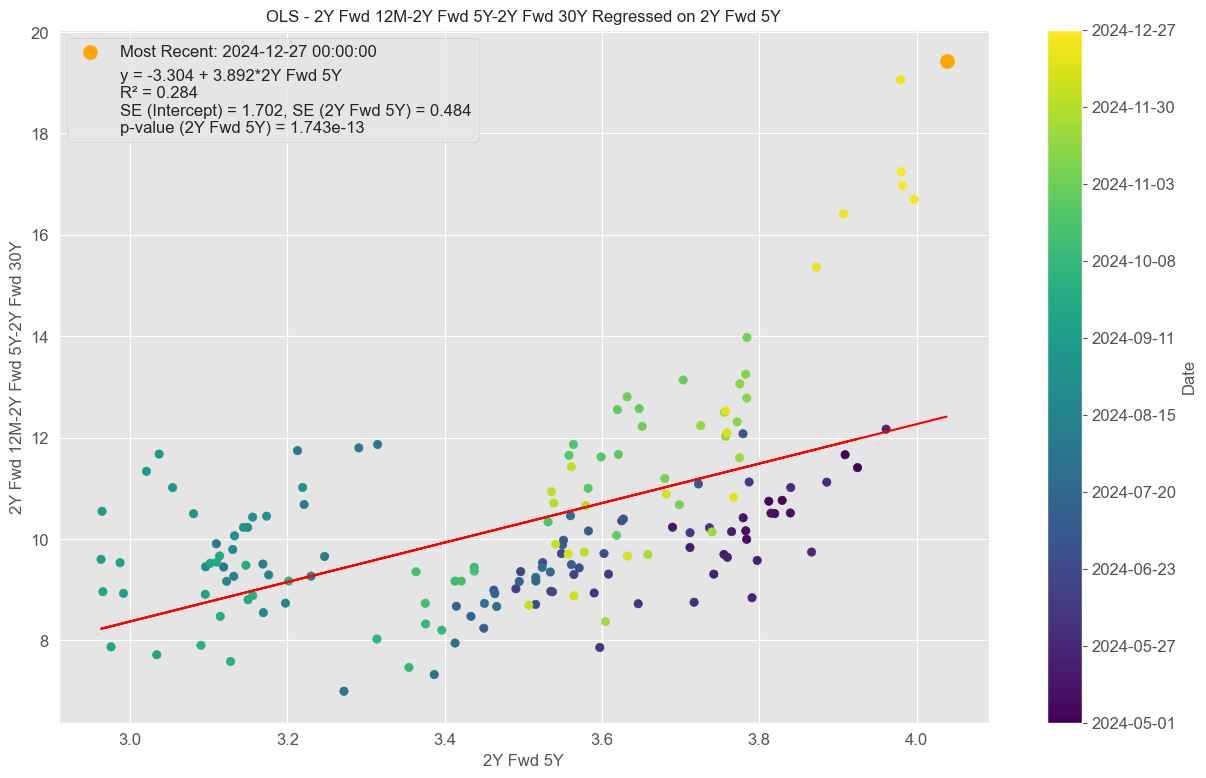

In [23]:
run_basic_linear_regression_df(
    df=timeseries_df,
    x_col="2Y Fwd 5Y",
    y_col="2Y Fwd 12M-2Y Fwd 5Y-2Y Fwd 30Y",
    plot_most_recent=True,
    date_color_bar=True,
)

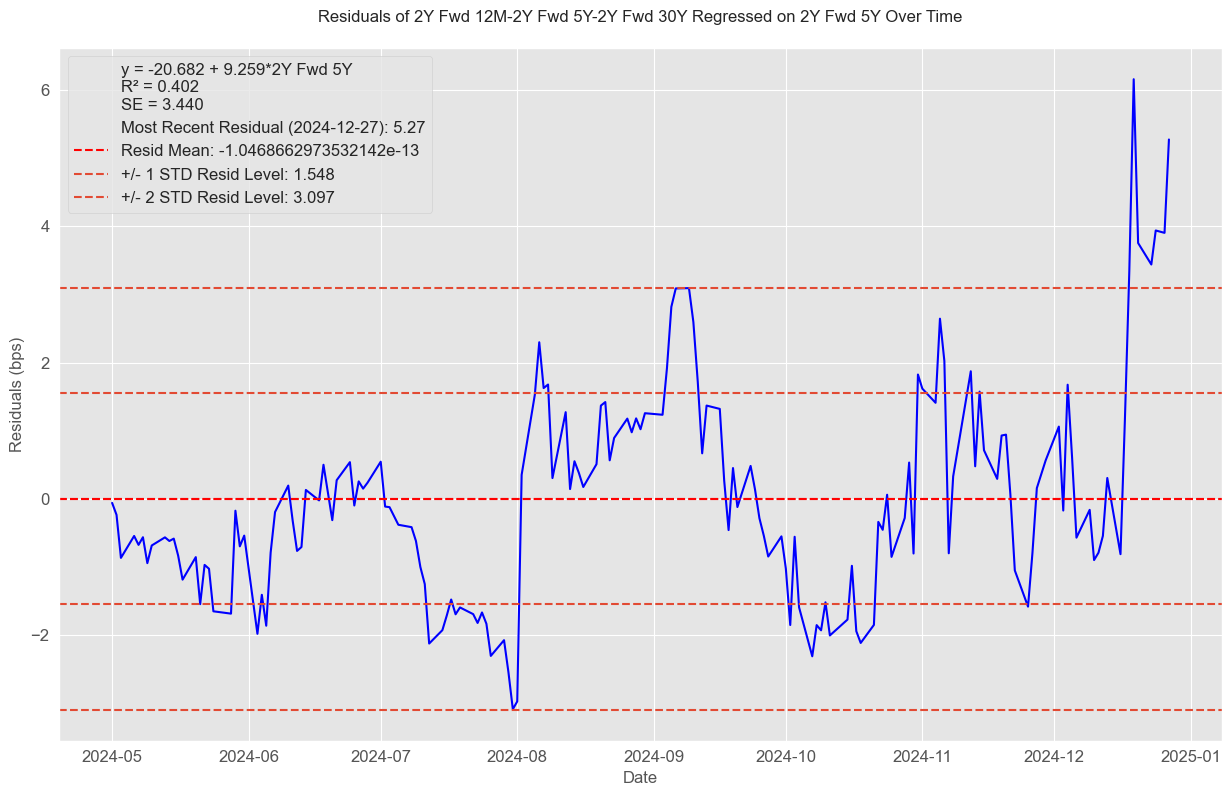

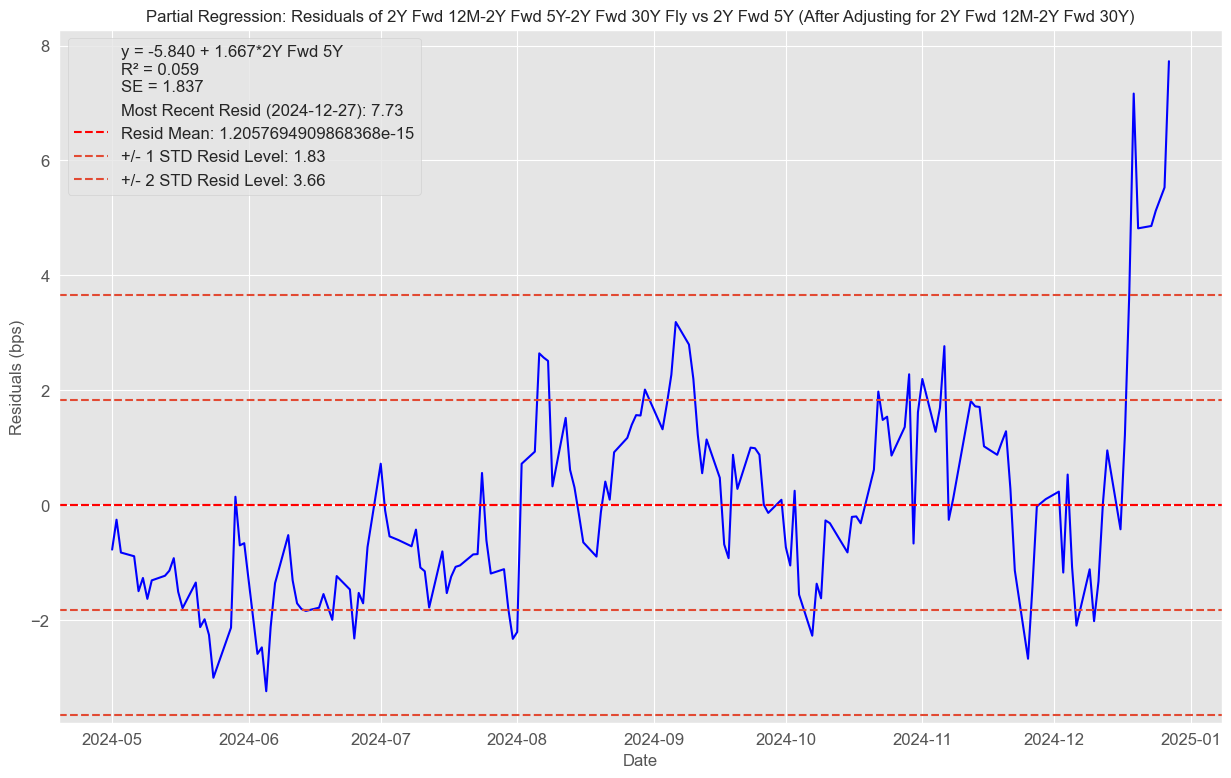

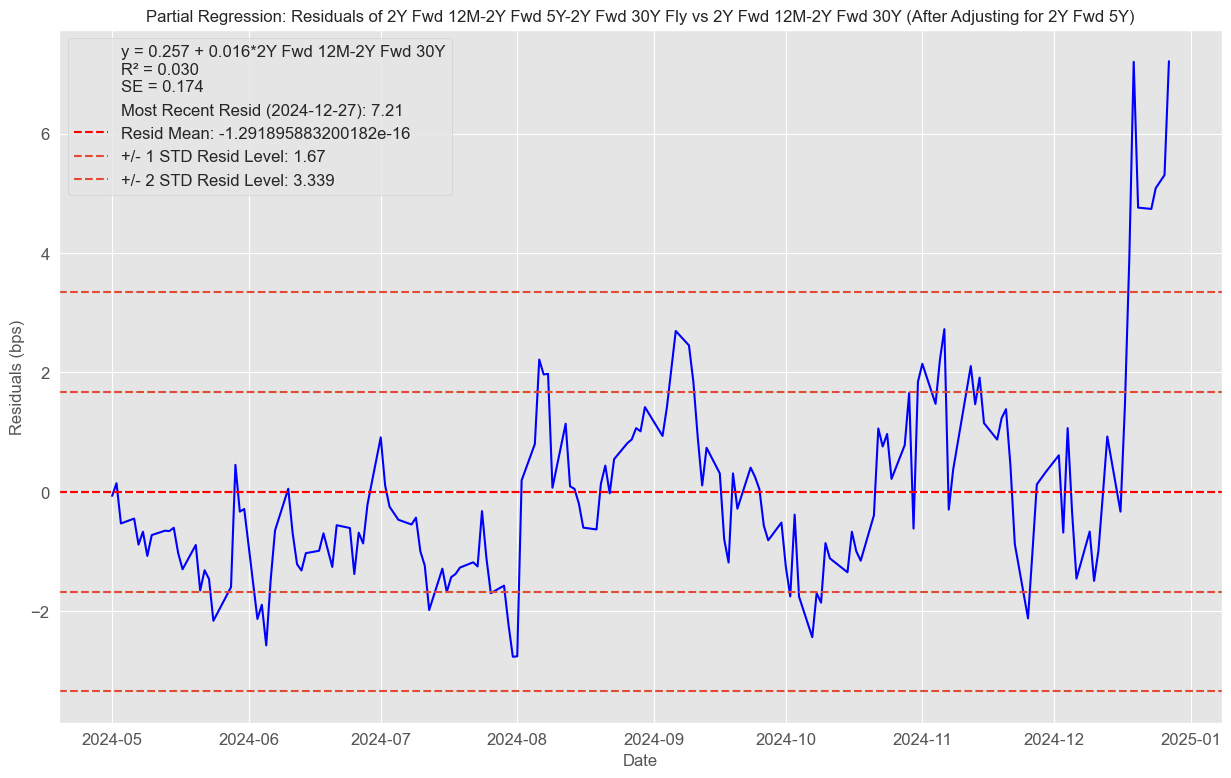

In [25]:
d, r = run_multiple_linear_regression_df(
    df=timeseries_df, x_cols=["2Y Fwd 5Y", "2Y Fwd 12M-2Y Fwd 30Y"], y_col="2Y Fwd 12M-2Y Fwd 5Y-2Y Fwd 30Y", show_plot=False
)
plot_residuals_timeseries(df=timeseries_df, results=r, stds=[1, 2])

modified_partial_regression_fly_plot(
    df=timeseries_df,
    x_cols=["2Y Fwd 5Y", "2Y Fwd 12M-2Y Fwd 30Y"],
    y_col="2Y Fwd 12M-2Y Fwd 5Y-2Y Fwd 30Y",
    show_residual_timeseries=True,
    stds=[1, 2],
)
modified_partial_regression_fly_plot(
    df=timeseries_df,
    x_cols=["2Y Fwd 12M-2Y Fwd 30Y", "2Y Fwd 5Y"],
    y_col="2Y Fwd 12M-2Y Fwd 5Y-2Y Fwd 30Y",
    show_residual_timeseries=True,
    stds=[1, 2],
)

In [407]:
sofr_ois.pca_residual_credit_suisse_BBar_plot(
    pca_results=pca_results,
    tenors_to_plot=[
        "2Y",
        "3Y",
        "4Y",
        "5Y",
        "6Y",
        "7Y",
        "8Y",
        "9Y",
        "10Y",
        "12Y",
        "15Y",
        "20Y",
        "25Y",
        "30Y",
        "40Y",
        "50Y",
        "12M Fwd 12M",
        "12M Fwd 2Y",
        "12M Fwd 3Y",
        "12M Fwd 4Y",
        "12M Fwd 5Y",
        "12M Fwd 6Y",
        "12M Fwd 7Y",
        "12M Fwd 8Y",
        "12M Fwd 9Y",
        "12M Fwd 10Y",
        "12M Fwd 12Y",
        "12M Fwd 15Y",
        "12M Fwd 20Y",
        "12M Fwd 25Y",
        "12M Fwd 30Y",
        "12M Fwd 40Y",
        "12M Fwd 50Y",
    ],
    bday_offsets=[20, 5], 
    title="2024-12-24 PCA Residuals from YTD Spot & 12M Fwd SOFR OIS Daily Rates with 1W & 1M Old Residuals Overlaid (skinner & lighter => older)"
)